# Import packages and load data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from matplotlib import rc
xscaler = MinMaxScaler()

In [36]:
file_path = '../input_data/pspeo_master.xlsx'
model_output = 'order_disorder'
# import data frame for pre-processing
df = pd.read_excel(file_path)
df.head()

,sample,solv_ratio,add_type,swell_ratio,gisaxs_domain,gisaxs_fwhm,afm_domain,afm_grain,order_disorder
0,I_A_AC,80/20,Chloronaphthalene,1.00,31.302630,0.003697,33.737303,0.0048,0
1,I_A025,80/20,Chloronaphthalene,1.25,33.805848,0.003136,35.151690,0.0047,0
2,I_A050,80/20,Chloronaphthalene,1.50,34.176062,0.002970,35.397797,0.0534,0
3,I_A075,80/20,Chloronaphthalene,1.75,34.383751,0.003451,34.603726,0.0425,0
4,I_A_100,80/20,Chloronaphthalene,2.00,31.674148,0.005122,33.786210,0.0244,0


# Grid-Search

In [37]:
# Assign input variables and target variable, eliminating static valuesp
inputs = df.loc[:, ['solv_ratio', 'swell_ratio', 'add_type']]
target = df['order_disorder']

# Define mapping for solv_ratio
type_mapping = {100: 1.0, '90/10': 0.9, '80/20': 0.8, '70/30': 0.7, '60/40': 0.6, '50/50': 0.5}
inputs['solv_ratio'] = inputs['solv_ratio'].replace(type_mapping)

# Encode categorical input 'add_type'
le_addType = LabelEncoder()
inputs['add_type'] = le_addType.fit_transform(inputs['add_type'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=10)

# Scale the x data for better fitting
xscaler.fit(X_train)
X_train = xscaler.transform(X_train)
X_test = xscaler.transform(X_test)
X_all = xscaler.transform(inputs)

# Data pre-processing

In [38]:
from joblib import dump, load
# Convert cv_results_ to DataFrame

best = load(f'raw_models/{model_output}.joblib')

In [39]:
train_r2 = best.score(X_train, y_train)
test_r2 = best.score(X_test, y_test)

print(f'Training r2: {train_r2}')
print(f'Testing r2: {test_r2}')

# Create an array for x values
x_len = len(y_test)
actual_x = np.arange(1, x_len+1)

# Define the output path for figures
output_path = f'final_figs/{model_output}/'

Training r2: 0.9813664596273292
Testing r2: 1.0


In [40]:
from sklearn.metrics import f1_score

# Make predictions using the best model
y_pred_train = best.predict(X_train)
y_pred_test = best.predict(X_test)

# Calculate the F1 score
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

print("Training F1 Score:", f1_train)
print("Testing F1 Score:", f1_test)

Training F1 Score: 0.9884169884169884
Testing F1 Score: 1.0


In [41]:
y_test_list = y_test.values

In [42]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for test data
y_pred_proba_train = best.predict_proba(X_train)[:, 1]
y_pred_proba_test = best.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

print("Training AUC Score:", auc_score_train)
print("Testing AUC Score:", auc_score_test)

Training AUC Score: 0.9989821882951655
Testing AUC Score: 1.0


# Visualize the results

In [43]:
# Make predictions using the best model
y_pred_full = best.predict(X_all)

# Calculate the F1 score
f1_full = f1_score(target, y_pred_full)

print("Training F1 Score:", f1_full)

Training F1 Score: 0.9906542056074766


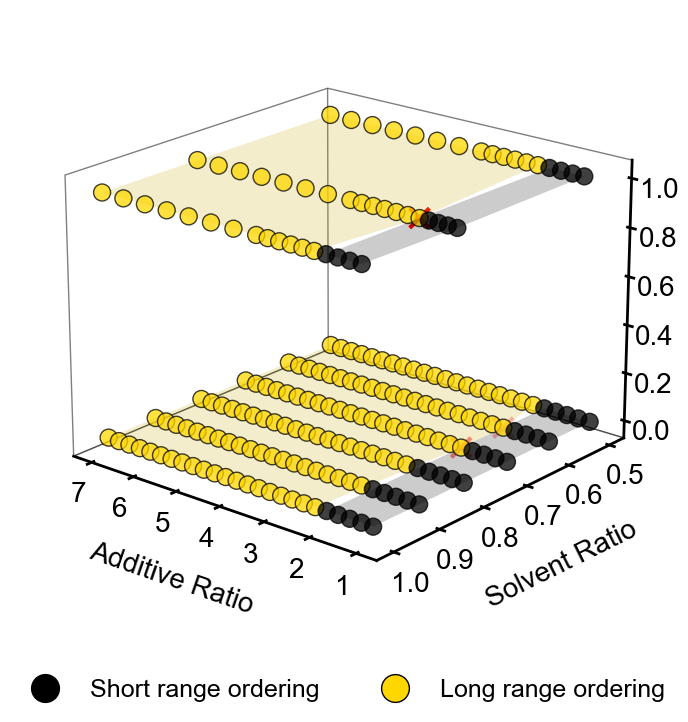

In [44]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import numpy as np
from scipy.spatial import Delaunay

fig_title = f'{model_output}_classification_scatter_3D'

%matplotlib inline
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=20)   
rc('xtick.major', size=7)  
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=20)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=25) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True}) 
plt.rcParams['font.family'] = 'Arial'

# Define class-to-color mapping and class names
class_labels = sorted(set(target))
class_colors = ['black', 'gold']
class_names = {0: 'Short range ordering', 1: 'Long range ordering'}
color_map = {label: class_colors[i % len(class_colors)] for i, label in enumerate(class_labels)}

# Map target labels to colors
colors = [color_map[label] for label in target]

# 3D figure and axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Set view angle
ax.view_init(elev=20, azim=130)

# Scatter plot color-coded by true class
ax.scatter(inputs['swell_ratio'], 
           inputs['solv_ratio'], 
           inputs['add_type'], 
           c=colors, s=150, alpha=0.75,
           marker='o', edgecolors='black', label='True Classes')

# Loop through each unique z (additive type) for class-based surfaces
for z_val in sorted(inputs['add_type'].unique()):
    for class_val in class_labels:
        mask = (inputs['add_type'] == z_val) & (target == class_val)
        x = inputs.loc[mask, 'swell_ratio'].values
        y = inputs.loc[mask, 'solv_ratio'].values
        z = np.full_like(x, z_val)

        if len(x) >= 3:
            tri = Delaunay(np.column_stack((x, y)))
            ax.plot_trisurf(
                x, y, z,
                triangles=tri.simplices,
                color=color_map[class_val],
                alpha=0.2,
                edgecolor='none'
            )

# Identify incorrect predictions
incorrect_mask = y_pred_full != target.values
incorrect_points = inputs[incorrect_mask]

# Labels with more spacing
ax.set_xlabel('Additive Ratio', fontsize=20, labelpad=20)
ax.set_ylabel('Solvent Ratio', fontsize=20, labelpad=20)
ax.set_zlabel('Additive Type', fontsize=20, labelpad=15)

# Legend with descriptive class names and incorrect marker
custom_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cls], 
               markeredgecolor='black', markersize=10, label=class_names[cls])
    for cls in class_labels
]
# custom_handles.append(
#     plt.Line2D([0], [0], marker='x', color='red', label='Incorrect Predictions',
#                markersize=10, linewidth=0, markeredgewidth=3)
# )

# Plot red Xs at incorrect predictions (ensure they appear on top)
ax.scatter(incorrect_points['swell_ratio'], 
           incorrect_points['solv_ratio'], 
           incorrect_points['add_type'], 
           c='red', s=200, marker='x', linewidths=3, zorder=0)

ax.legend(handles=custom_handles, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2, fontsize='18', markerscale=2, frameon=False)

# Remove grid background
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

ax.xaxis.line.set_color('black')
ax.yaxis.line.set_color('black')
ax.zaxis.line.set_color('black')

ax.xaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
ax.yaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
ax.zaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
ax.grid(False)

plt.savefig(output_path + fig_title, format='pdf')
plt.show()

In [53]:
print(len(target))

202


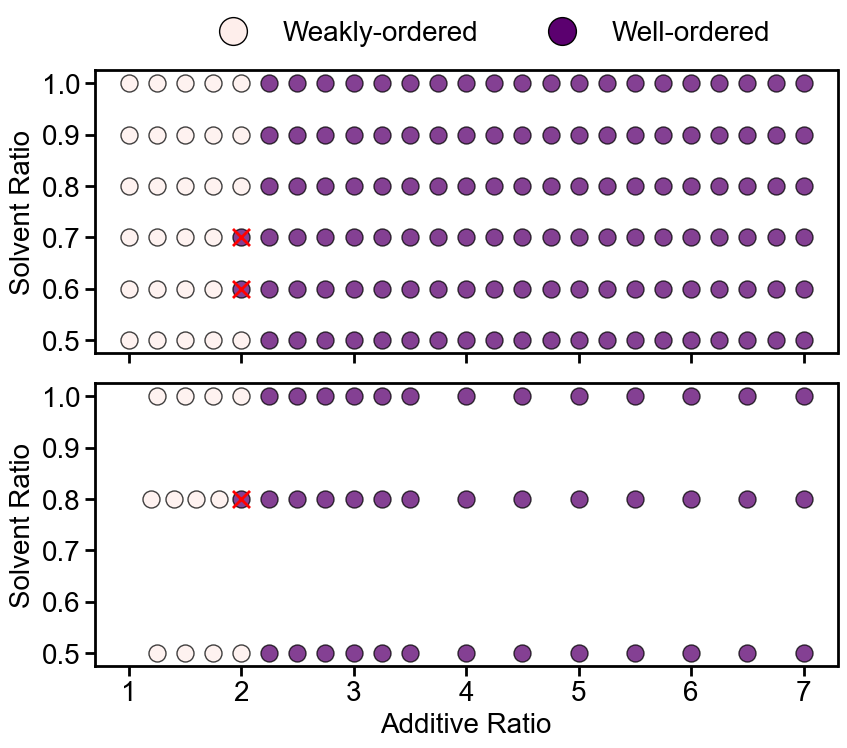

In [58]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import Normalize
import pandas as pd
import numpy as np

# Set up plotting parameters
%matplotlib inline
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=20)   
rc('xtick.major', size=7)  
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=20)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=25) 
rc('axes', linewidth=2) 
rc('font', family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right': True, 'top': True}) 
plt.rcParams['font.family'] = 'Arial'

fig_title = f'{model_output}_classification_scatter_2D'

# Colormap setup
cmap = plt.cm.RdPu
norm = Normalize(vmin=0, vmax=1)

# Class-to-color mapping using normalized colormap
class_labels = sorted(set(target))
class_norm_vals = {0: 0.05, 1: 0.95}
class_colors = {label: cmap(norm(class_norm_vals[label])) for label in class_labels}
class_names = {0: 'Weakly-ordered', 1: 'Well-ordered'}

# Create 2 subplots
unique_add_types = sorted(inputs['add_type'].unique())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7.5), sharex=True)

axes = [ax1, ax2]

for idx, add_type in enumerate(unique_add_types):
    ax = axes[idx]
    subset = inputs[inputs['add_type'] == add_type]
    subset_target = target[inputs['add_type'] == add_type]
    
    # Scatter plot color-coded by true class
    for class_val in class_labels:
        mask = subset_target == class_val
        ax.scatter(subset.loc[mask, 'swell_ratio'],
                   subset.loc[mask, 'solv_ratio'],
                   color=class_colors[class_val],  # <- fixed
                   s=150, alpha=0.75,
                   marker='o', edgecolors='black',
                   label=class_names[class_val] if idx == 0 else None)

    # subset_pred = y_pred_full
    incorrect_mask = target != y_pred_full

    # Red 'x' for incorrect predictions
    ax.scatter(subset.loc[incorrect_mask, 'swell_ratio'],
               subset.loc[incorrect_mask, 'solv_ratio'],
               color='red', marker='x', s=150, linewidths=2,
               label='Incorrect Prediction' if idx == 0 else None)

    # Labels
    if idx == 1:
        ax.set_xlabel('Additive Ratio', fontsize=20)
    ax.set_ylabel('Solvent Ratio', fontsize=20)

    # Title moved to the right, vertical
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_text = xlim[1] + (xlim[1] - xlim[0]) * 0.05  # slightly outside right
    y_text = (ylim[0] + ylim[1]) / 2  # middle of y-axis

    # ax.text(x_text, y_text, f'Additive Type:{add_type}', 
            # fontsize=20, va='center', ha='left', rotation=270)

    ax.grid(False)
    ax.set_yticks(np.arange(0.5, 1.01, 0.1))
    # ax.set_ylabel('Solvent Ratio', fontsize=20)
    ax.set_yticks(np.arange(0.5, 1.01, 0.1))  # <-- Add this line

    # Set spines
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

# Create a single shared legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[cls], 
               markeredgecolor='black', markersize=10, label=class_names[cls])
    for cls in class_labels
]

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.02),
           fancybox=True, shadow=True, ncol=2, fontsize=20, frameon=False, markerscale=2)

fig.tight_layout()
plt.subplots_adjust(top=0.92, right=0.85)  # leave space for right-side text
plt.savefig(output_path + fig_title, format='pdf')
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

y_pred = []
y_true = []

# Define the figure title
fig_title = f'confusion_bin_image'

# Create the plasma colormap and its reverse
colors = ["#FFD700", "#000000"]
# cmap = LinearSegmentedColormap.from_list("gold_to_black", colors)
cmap = plt.cm.RdPu

# constant for classes
classes = ['Weakly-ordered', 'Well-ordered']

# Build confusion matrix
cf_matrix = confusion_matrix(target.values, y_pred_full)

In [47]:
from matplotlib import rc
%matplotlib inline
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=20)   
rc('xtick.major', size=7)  
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=20)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=25) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True}) 
plt.rcParams['font.family'] = 'Arial'

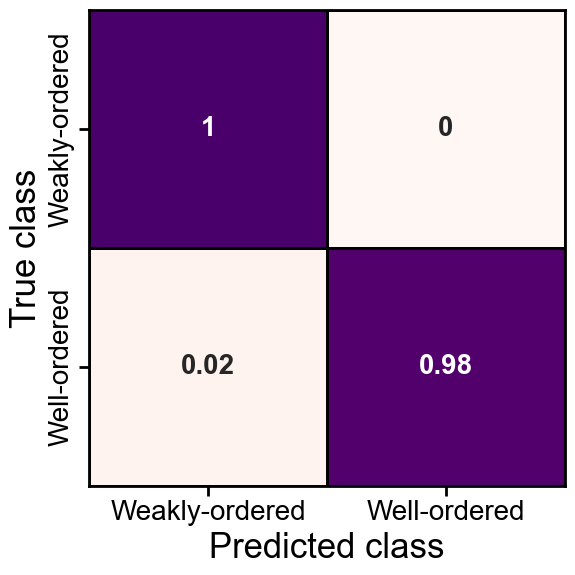

In [49]:
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], 
                     index=[i for i in classes],
                     columns=[i for i in classes]).round(2)

# Creating the heatmap without a color bar
plt.figure(figsize=(6,6))
ax = sn.heatmap(df_cm, cmap=cmap, annot=True, annot_kws={'weight': 'bold', 'fontsize': 20}, 
                linewidths=2, linecolor='black', cbar=False)

# Adding axis labels
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')

# Adding an outline to the heatmap
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.tight_layout()
plt.savefig(output_path + fig_title, format='pdf')